<a href="https://www.kaggle.com/code/lukalafaye/rl-homework?scriptVersionId=210664643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Retail Store Management

**This is your INDIVIDUAL homework that needs to be returned by November 30, 2024, at the latest, as a functional completed Python notebook file. Late submissions will be applied a penalty.** Please print your name here and be sure to name your file <code>YourFirstName-YOURLASTNAME-retail_store.ipynb</code> and to send it by email to <olivier.cappe@ens.fr> before the deadline.

# Luka Lafaye de Micheaux

We consider, the *retail store management* model seen in the course.

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $X_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [58]:
# Please REFRAIN from importing any additional module
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

#The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [59]:
# Utility functions for the Retail store environment (do NOT modify this code block)

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m #Stock capacity
        self.h = h #Maintenance cost per unit
        self.c = c #Buying price per unit
        self.f = f #Selling price per unit
        self.d = d #Weekly average demand
        
    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state -self.c*action + self.f*min([demand, self.state+action, self.m])
        #Update the time and state variables
        self.time += 1
        self.state = max([min([self.state+action, self.m])-demand, 0])
        return reward

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                #Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a + self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1))
        for s in range(self.m+1):
            for a in range(self.m+1):
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d)
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function()
        r_pi = np.sum(np.multiply(r, pi), axis=1)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function()
        p_pi = np.zeros((self.m+1, self.m+1))
        for s in range(self.m+1):
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi)
        p_pi = self.transition_policy(pi)
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi        

# Experiments

## Q1. Simulation of Fixed Ordering Policies

We will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$ **(Comment these choice of parameters).** By simulating trajectories from the model **(discuss what length is necessary)** get an empirical idea of **how well fixed-ordering (i.e. ordering always the same quantity of goods) perform?** Use the <code>env.value_policy</code> to **plot the value functions of the fixed-ordering policies.** **What is your interpretation of the results? Do you think that there are better policies?**

In [61]:
#Instantiate the retail store environment with the selected parameters 
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

#Just an example of simulating a short trajectory and computing the cumulated reward  
env.reset(m)
n = 12
w = 1
v = 0
for _ in range(n):
    x = env.step(3)
    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

"""
Choice of parameters:
Warehouse capacity (m=9) keeps the state space size small
Maintenance cost (h=0.1) makes holding items from one week to another not cost much
Ordering cost (c=0.5) is half the sales profit
Sales profit (f=1) is double the ordering cost
Average demand (d=4) makes it possible to experience both overstock and stockout situations
Discount factor (gamma=0.875) is the trade-off between immediate and future rewards
"""

0 :  -1.4  -> 8
1 :  -0.3  -> 7
2 :  5.8  -> 1
3 :  0.4  -> 2
4 :  1.3  -> 2
5 :  3.3  -> 0
6 :  1.5  -> 0
7 :  -0.5  -> 2
8 :  0.3  -> 3
9 :  0.2  -> 4
10 :  -0.9  -> 6
11 :  2.9  -> 4
Discounted reward: 6.6


'\nChoice of parameters:\nWarehouse capacity (m=9) keeps the state space size small\nMaintenance cost (h=0.1) makes holding items from one week to another not cost much\nOrdering cost (c=0.5) is half the sales profit\nSales profit (f=1) is double the ordering cost\nAverage demand (d=4) makes it possible to experience both overstock and stockout situations\nDiscount factor (gamma=0.875) is the trade-off between immediate and future rewards\n'

Fixed-ordering policy A=0: Average Value = 3.60
Fixed-ordering policy A=1: Average Value = 7.22
Fixed-ordering policy A=2: Average Value = 10.40
Fixed-ordering policy A=3: Average Value = 12.39
Fixed-ordering policy A=4: Average Value = 11.50
Fixed-ordering policy A=5: Average Value = 8.06
Fixed-ordering policy A=6: Average Value = 4.04
Fixed-ordering policy A=7: Average Value = -0.01
Fixed-ordering policy A=8: Average Value = -4.04
Fixed-ordering policy A=9: Average Value = -8.06


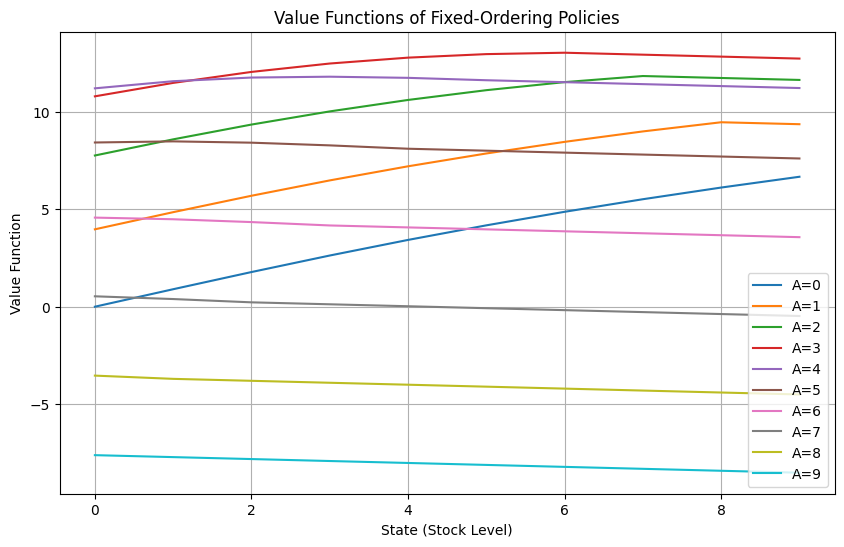

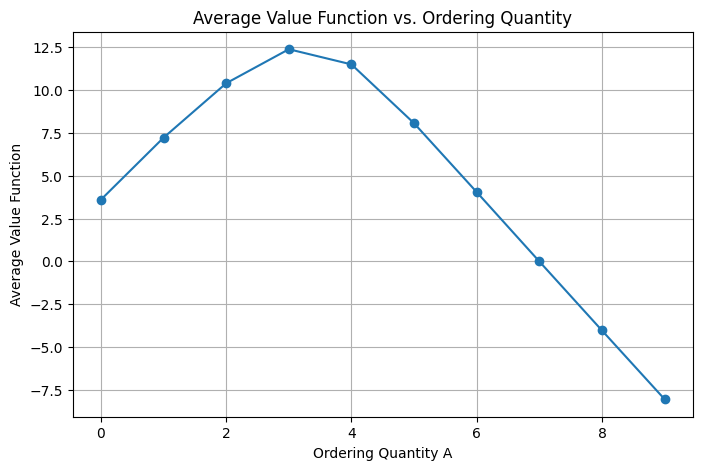

'\nInterpretation\nThe average value function is maximized for quantity 3 (seems like the optimal number for a fixed ordering policy)\nOrdering too little (A<2) can lead to stockouts\nOrdering too much (A>6) increases holding and ordering costs without proportionate profit gains\nThere are better policies that adjust orders based on current stock levels to optimize performance.\nState-dependent policies can reduce unnecessary costs and avoid stockouts more effectively than fixed-ordering policies.\n'

In [62]:
values = []
avg_values = []
ordering_quantities = range(m+1)

for A in ordering_quantities:
    pi_A = np.zeros((m+1, m+1))# fixed ordering policy
    for s in range(m+1):
        pi_A[s, A] = 1  
    v_pi_A = env.value_policy(pi_A, gamma)
    values.append(v_pi_A)
    avg_value = np.mean(v_pi_A)# avg value over all states
    avg_values.append(avg_value)
    print(f'Fixed-ordering policy A={A}: Average Value = {avg_value:.2f}')

plt.figure(figsize=(10, 6))
for A, v_pi_A in zip(ordering_quantities, values):
    plt.plot(range(m+1), v_pi_A, label=f'A={A}')
plt.xlabel('State (Stock Level)')
plt.ylabel('Value Function')
plt.title('Value Functions of Fixed-Ordering Policies')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(ordering_quantities, avg_values, marker='o')
plt.xlabel('Ordering Quantity A')
plt.ylabel('Average Value Function')
plt.title('Average Value Function vs. Ordering Quantity')
plt.grid(True)
plt.show()

"""
Interpretation
The average value function is maximized for quantity 3 (seems like the optimal number for a fixed ordering policy)
Ordering too little (A<2) can lead to stockouts
Ordering too much (A>6) increases holding and ordering costs without proportionate profit gains
There are better policies that adjust orders based on current stock levels to optimize performance.
State-dependent policies can reduce unnecessary costs and avoid stockouts more effectively than fixed-ordering policies.
"""

## Q2. Computing the Optimal Policy
Obtain the optimal policy by **implementing the Policy Iteration algorithm** (use the <code>env.value_policy</code> to compute the value function). **How do you know that it has converged?** **What does the optimal policy do?** **Comment the form of the value function.**

Iteration 1: Policy Stable = False
Iteration 2: Policy Stable = True
Optimal Policy: [5 4 3 2 1 0 0 0 0 0]


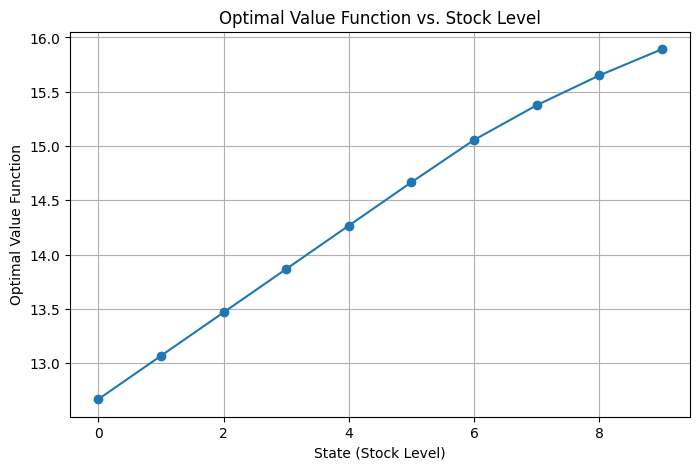

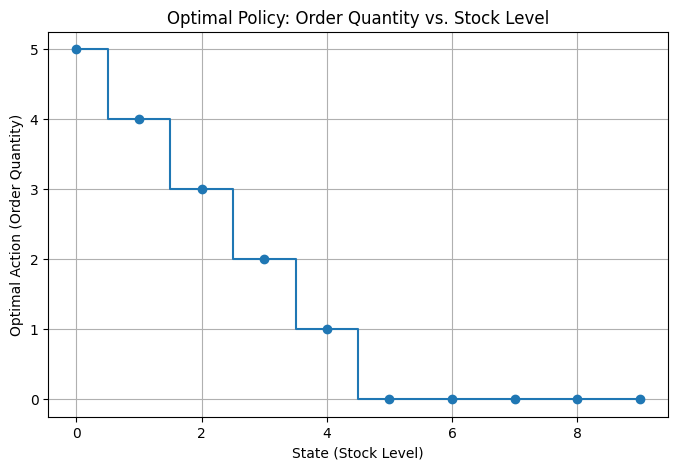

State (Stock Level) -> Optimal Action (Order Quantity)
0 -> 5
1 -> 4
2 -> 3
3 -> 2
4 -> 1
5 -> 0
6 -> 0
7 -> 0
8 -> 0
9 -> 0


In [63]:
num_states = m + 1 
num_actions = m + 1
policy = np.ones((num_states, num_actions)) / num_actions

def policy_improvement(env, policy, gamma):
    is_policy_stable = True
    v_pi = env.value_policy(policy, gamma)
    r = env.reward_function()
    p = env.transition_function()
    
    for s in range(num_states):
        old_action = np.argmax(policy[s])
        action_values = np.zeros(num_actions)
        for a in range(num_actions):
            action_values[a] = r[s, a] + gamma * np.dot(p[s, a], v_pi)
        best_action = np.argmax(action_values)
        new_policy = np.zeros(num_actions)
        new_policy[best_action] = 1.0
        if not np.array_equal(policy[s], new_policy):
            is_policy_stable = False
        policy[s] = new_policy
    return policy, is_policy_stable

iteration = 0
while True:
    iteration += 1
    v_pi = env.value_policy(policy, gamma)
    policy, is_policy_stable = policy_improvement(env, policy, gamma)
    print(f'Iteration {iteration}: Policy Stable = {is_policy_stable}')
    if is_policy_stable:
        break

optimal_policy = np.argmax(policy, axis=1)
print('Optimal Policy:', optimal_policy)

v_optimal = v_pi
plt.figure(figsize=(8, 5))
plt.plot(range(num_states), v_optimal, marker='o')
plt.xlabel('State (Stock Level)')
plt.ylabel('Optimal Value Function')
plt.title('Optimal Value Function vs. Stock Level')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.step(range(num_states), optimal_policy, where='mid', marker='o')
plt.xlabel('State (Stock Level)')
plt.ylabel('Optimal Action (Order Quantity)')
plt.title('Optimal Policy: Order Quantity vs. Stock Level')
plt.grid(True)
plt.show()


print('State (Stock Level) -> Optimal Action (Order Quantity)')
for s in range(num_states):
    print(f'{s} -> {optimal_policy[s]}')

How do we know that it has converged?

The algorithm converges when the policy does not change during the policy improvement step.
We check for policy stability in each iteration; when is_policy_stable becomes True, the policy has converged.

What does the optimal policy do?

The optimal policy is state-dependent. It prescribes ordering quantities based on the current stock level. It aims to maintain an optimal inventory level by ordering just enough to reach a target stock level.

Comment on the form of the value function:
The optimal value function increases with the stock level.

## Q3. Q Learning
**Implement the asynchronous Q-Learning algorithm using the purely random policy (all actions selected uniformly) as the exploration policy** (note: this requires only about 10 lines of code). **Plot the convergence of the algorithm** both in terms of convergence of the state-action value table $Q_t$ and of convergence of the value function of the associated greedy policy $\pi_{t+}(s) = \arg\max_a Q_t(s,a)$. Use a single trajectory of length $n = 10,000$ and **test different schemes of decrease** of the learning rate (following the course guidelines). ***Explain the behaviors that you observe***.

In [25]:
num_states = m + 1
num_actions = m + 1
num_episodes = 1
max_steps = 10000

Q = np.zeros((num_states, num_actions))

visit_counts = np.zeros((num_states, num_actions))

def learning_rate_scheme(t, s, a):
    alpha_const = 0.1
    return alpha_const

def learning_rate_scheme_decay(t, s, a):
    alpha_decay = 1.0 / (t + 1)
    return alpha_decay

def learning_rate_scheme_visit_counts(t, s, a):
    visit_counts[s, a] += 1
    alpha_visits = 1.0 / visit_counts[s, a]
    return alpha_visits


def exploration_policy(state):
    return np.random.choice(num_actions)

def run_q_learning(alpha_scheme):
    Q_convergence = []
    policy_values = []
    steps = []
    
    state = np.random.randint(0, num_states)
    env.reset(state)
    
    for t in range(max_steps):
        action = exploration_policy(state)
        
        reward = env.step(action)
        next_state = env.state
        
        alpha = alpha_scheme(t, state, action)
        
        best_next_action = np.argmax(Q[next_state])
        td_target = reward + gamma * Q[next_state, best_next_action]
        Q[state, action] = (1 - alpha) * Q[state, action] + alpha * td_target
        
        if t % 100 == 0:
            Q_convergence.append(np.mean(np.abs(Q)))
            steps.append(t)
            
            greedy_policy = np.zeros((num_states, num_actions))
            for s in range(num_states):
                best_action = np.argmax(Q[s])
                greedy_policy[s, best_action] = 1.0
            v_pi = env.value_policy(greedy_policy, gamma)
            avg_value = np.mean(v_pi)
            policy_values.append(avg_value)
        
        state = next_state
    
    plt.figure(figsize=(10, 5))
    plt.plot(steps, Q_convergence)
    plt.xlabel('Time Steps')
    plt.ylabel('Mean Absolute Q-value')
    plt.title('Convergence of Q-table over Time')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 5))
    plt.plot(steps, policy_values)
    plt.xlabel('Time Steps')
    plt.ylabel('Average Value Function of Greedy Policy')
    plt.title('Convergence of Greedy Policy Value over Time')
    plt.grid(True)
    plt.show()

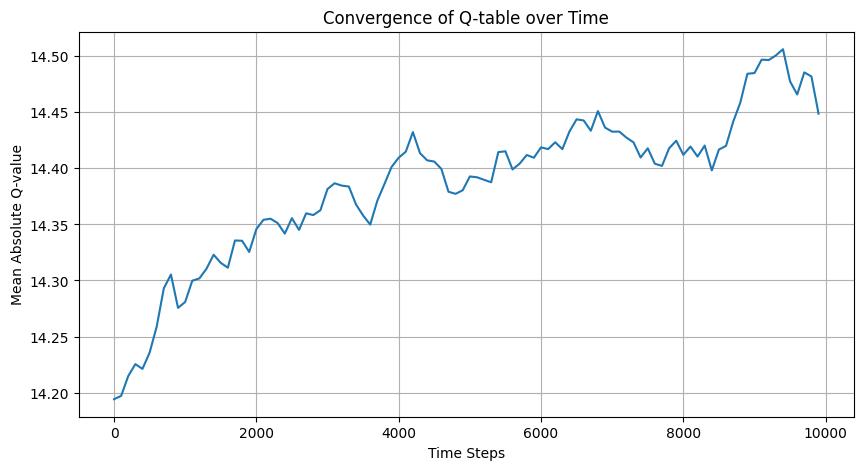

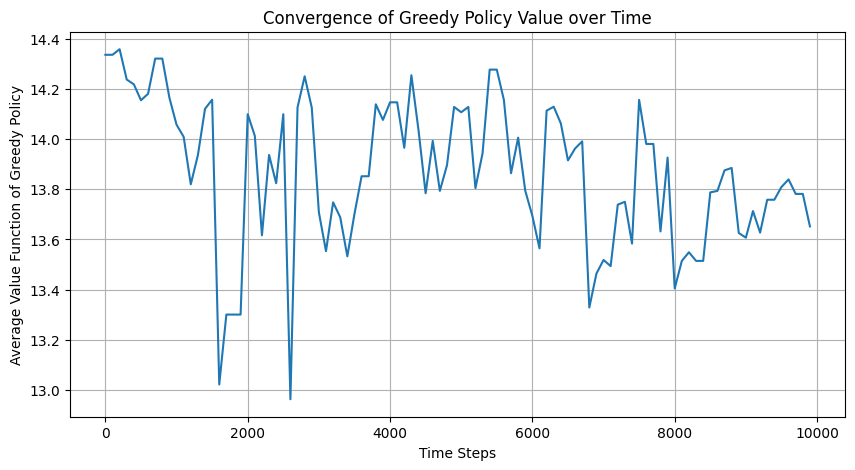

In [29]:
alpha_scheme = learning_rate_scheme
run_q_learning(alpha_scheme)

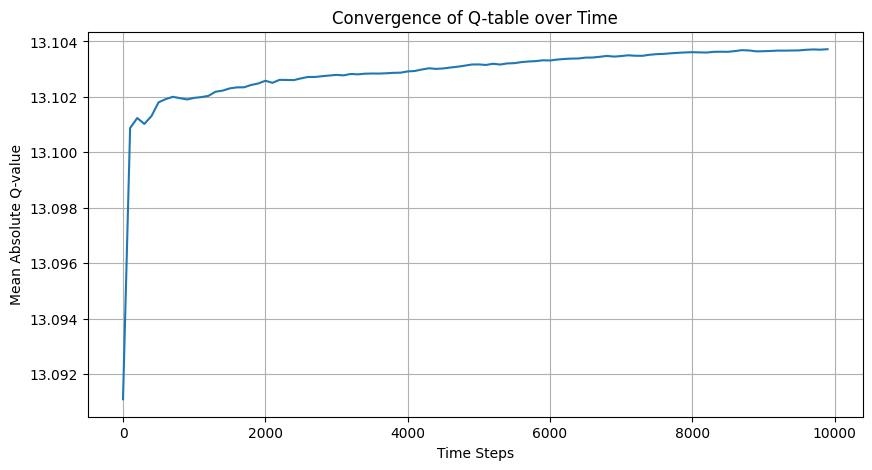

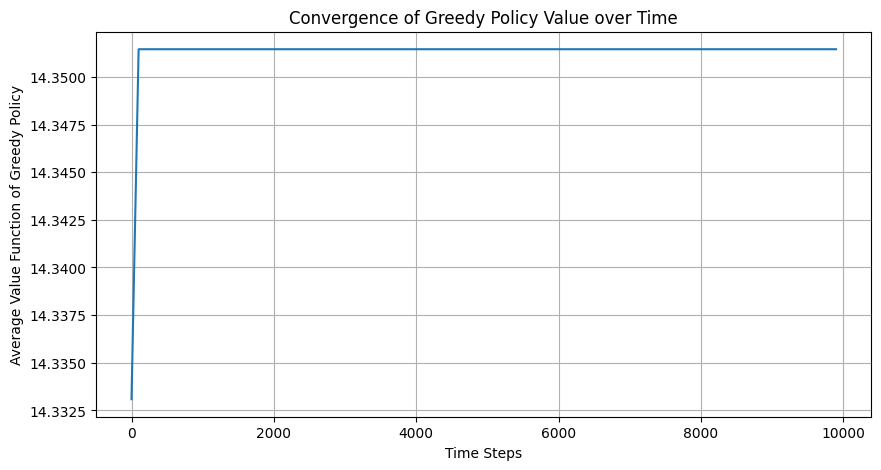

In [27]:
alpha_scheme = learning_rate_scheme_decay
run_q_learning(alpha_scheme)

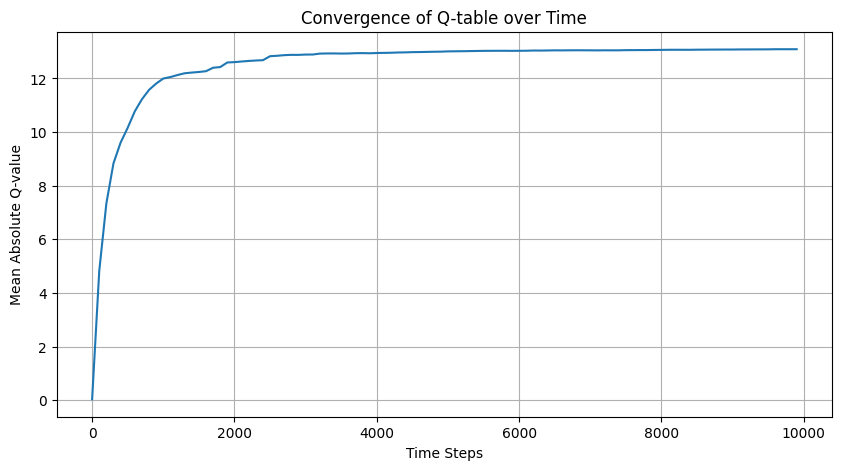

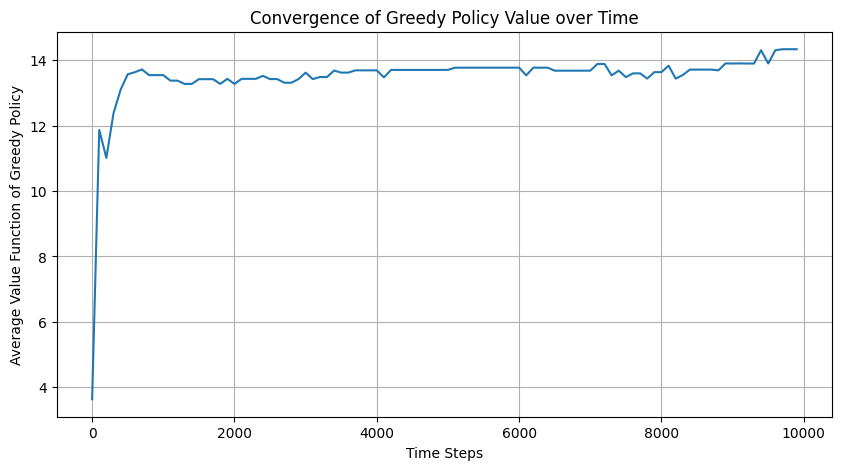

In [26]:
alpha_scheme = learning_rate_scheme_visit_counts
run_q_learning(alpha_scheme)

Interpretation

With a constant learning rate, there are continuous adjustments even after reaching near-optimal Q-values and both the Q table and policy value graphs do not converge.

With the learning_rate_scheme_decay, the learning rate increases with time making it possible to converge while gradually exploring, the Q table and policy value graphs converge smoothly because as the learning rate diminishes updates become smaller.

With the learning_rate_scheme_visit_counts, the convergence is much faster compared to learning_rate_scheme_decay. Frequently visited state actions pairs are "less" updated over time. Initial large lr values allows for significant updates while later as the visits counts increases, the lr decreases and the Q values are refined.

---

There is a tradeoff between exploration and exploitation and we try to solve it best using different learning rate schemes. The best one seems to be using visit counts.

## Q4. Policy Gradient

We will now consider using policy gradient from a set of simulated trajectories using the REINFORCE formula to approximate the gradient of the value function. To do so, we consider a log-linear parameterization of the policy and provide the two utility functions below.

<code>policy_features</code> Computes a $2(m+1)$--dimensional feature vector $\phi(s,a)$ corresponding to the state-action pair $(s,a)$.

<code>policy_choice</code> Computes the vector $\pi_\theta(s,:)$ of action probabilities using the softmax operator:
$$
    \pi_\theta(s,a) = \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^T \phi(s,a')\right)}
$$
You should check from the code that the matrix $(\theta^T \phi(s,a))_{0\leq s,a \leq n}$ is a weighted sum of the $m+1$ fixed ordering policies and of the $m+1$ threshold policies (which you should have met already...)

In [64]:
#Policy gradient utility functions (do NOT modify this code block)

def policy_features(s, a, m):
    """Returns the feature vector corresponding to state (s,a)."""
    f = np.zeros(2*(m+1))
    #Index of the fixed ordering policy that is non zero in (s,a)
    f[a] = 1
    #Indices of the threshold policies that are non zero in (s,a)
    if (s+a <= m):
        f[(m+1)+s+a] = 1
    if (a == 0):
        for i in range(0,s+1):
            f[(m+1)+i] = 1
    return f

def policy_choice(s, m,theta):
    """Returns the vector of action probabilities pi(s,:) corresponding to state s and parameter theta."""
    pi = np.zeros(m+1)
    #Note : Computation in log to avoid numerical underflows
    for a in range(m+1):
        pi[a] = np.dot(policy_features(s, a, m), theta)
    pi = pi - np.max(pi)
    pi = np.exp(pi)/np.sum(np.exp(pi))
    return pi

**Code a function** <code>policy_gradient</code> that computes the gradient $\nabla_\theta \log\pi_\theta(s,a)$. First **write in the text block below the LaTeX formula implemented by the function, explaining how you obtain this formula.****

To compute the gradient of the log-policy with respect to the parameter θ, we start from the definition of the policy:

$$
\pi_\theta(s,a) = \frac{\exp\left(\theta^\top \phi(s,a)\right)}{\sum_{a'=0}^m \exp\left(\theta^\top \phi(s,a')\right)}
$$

The log of the policy is:

$$
\log \pi_\theta(s,a) = \theta^\top \phi(s,a) - \log\left(\sum_{a'=0}^m \exp\left(\theta^\top \phi(s,a')\right)\right)
$$

To find the gradient $$\nabla_\theta \log \pi_\theta(s,a)$$ we differentiate the log-policy with respect to θ:

$$
\nabla_\theta \log \pi_\theta(s,a) = \nabla_\theta \left( \theta^\top \phi(s,a) - \log\left(\sum_{a'=0}^m \exp\left(\theta^\top \phi(s,a')\right) \right) \right)
$$

Computing the derivatives:

**First Term:**

$$
\nabla_\theta \left( \theta^\top \phi(s,a) \right) = \phi(s,a)
$$

**Second Term:**

$$
\nabla_\theta \left( -\log\left(\sum_{a'=0}^m \exp\left(\theta^\top \phi(s,a')\right) \right) \right) = -\frac{\sum_{a'=0}^m \exp\left( \theta^\top \phi(s,a') \right) \phi(s,a') }{ \sum_{a'=0}^m \exp\left( \theta^\top \phi(s,a') \right) } = -\sum_{a'=0}^m \pi_\theta(s,a') \phi(s,a')
$$

Gradient of the log-policy:
$$
\nabla_\theta \log \pi_\theta(s,a) = \phi(s,a) - \sum_{a'=0}^m \pi_\theta(s,a') \phi(s,a')
$$

In [33]:
def policy_gradient(s, a, m, theta):
    phi_sa = policy_features(s, a, m)
    pi_s = policy_choice(s, m, theta)
    expected_phi = np.zeros_like(theta)
    for a_prime in range(m + 1):
        phi_sap = policy_features(s, a_prime, m)
        expected_phi += pi_s[a_prime] * phi_sap
    grad = phi_sa - expected_phi
    return grad

**Implement the policy gradient algorithm** approximating the gradients using the REINFORCE formula
$$
  \sum_{t=0}^{n} \gamma^t \left(\sum_{i=0}^{n} \gamma^i X_{t+i} \right) \nabla_\theta \log \pi_\theta(S_t, A_t)
$$
computed on trajectories of length 35 started from a random initial state and using 200 iterations of SGD updates. To do so, complete the code template provided below. **Monitor the convergence of the algorithm by plotting the difference between the mean of the optimal value function and the mean of the value functions corresponding to successive values of $\theta$ (explain why one considers the mean). Run the algorithm several times with the same and then different parameters (number of iterations, learning rate). What do you observe?**

In [56]:
# --- Your answer here (edit this block as needed) ---
n = 35
nb_iter = 500


# Compute optimal policy using policy iteration
num_states = m + 1
num_actions = m + 1
policy = np.ones((num_states, num_actions)) / num_actions

iteration = 0
while True:
    iteration += 1
    v_pi = env.value_policy(policy, gamma)
    policy, is_policy_stable = policy_improvement(env, policy, gamma)
    if is_policy_stable:
        break

v_optimal = v_pi
mean_v_optimal = np.mean(v_optimal)

######################################################################################################
theta = np.zeros(2*(m+1))  # Initialize theta to zeros
mean_v_theta = []          # To store the mean value functions
differences = []           # To store differences from optimal
alpha_base = 0.1          # Base learning rate

for i_iter in range(nb_iter):
    # Compute the REINFORCE approximation of the gradient of the value function from a run of length n
    # of the MDP initialized t a random state and using the policy corresponding to the current value of theta
    grad = np.zeros(2*(m+1))
    
    S = []
    A = []
    X = []
    log_pi_grads = []
    
    s = np.random.randint(0, m+1)
    env.reset(s)
    
    for t in range(n):
        pi_s = policy_choice(s, m, theta)
        a = np.random.choice(range(m+1), p=pi_s)
        x = env.step(a)
        s_next = env.state
        S.append(s)
        A.append(a)
        X.append(x)
        grad_log_pi = policy_gradient(s, a, m, theta)
        log_pi_grads.append(grad_log_pi)
        s = s_next
    
    G = np.zeros(n)
    for t in range(n):
        G_t = 0
        discount = 1.0
        for k in range(t, n):
            G_t += discount * X[k]
            discount *= gamma
        G[t] = G_t
    
    for t in range(n):
        grad += (gamma ** t) * G[t] * log_pi_grads[t]
    
    alpha = 0.1 * np.power(1 + i_iter, -0.6)
    theta += alpha * grad
    
    # Compute  value fn corresponding to current theta
    # Construct policy pi_theta
    pi_theta = np.zeros((num_states, num_actions))
    for s in range(num_states):
        pi_s = policy_choice(s, m, theta)
        pi_theta[s, :] = pi_s
    
    v_theta = env.value_policy(pi_theta, gamma)
    mean_v = np.mean(v_theta)
    mean_v_theta.append(mean_v)
    
    # Compare to optimal mean value
    diff = mean_v_optimal - mean_v
    differences.append(diff)

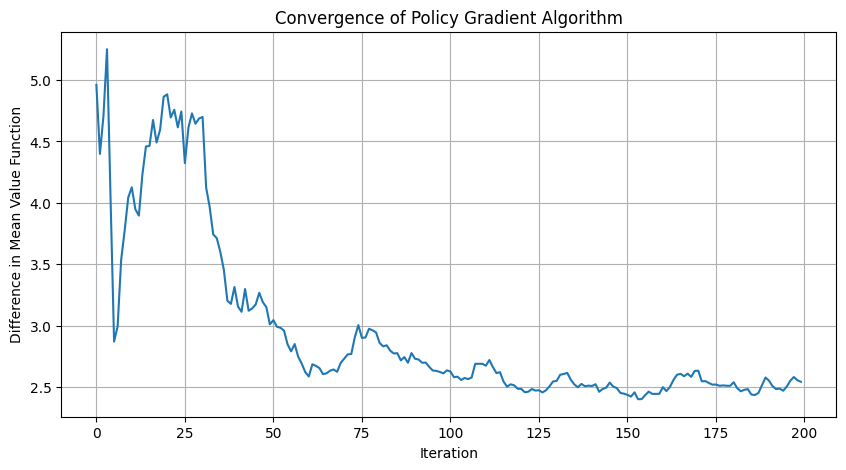

In [37]:
# Run 1 - lr 0.1 - 200 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

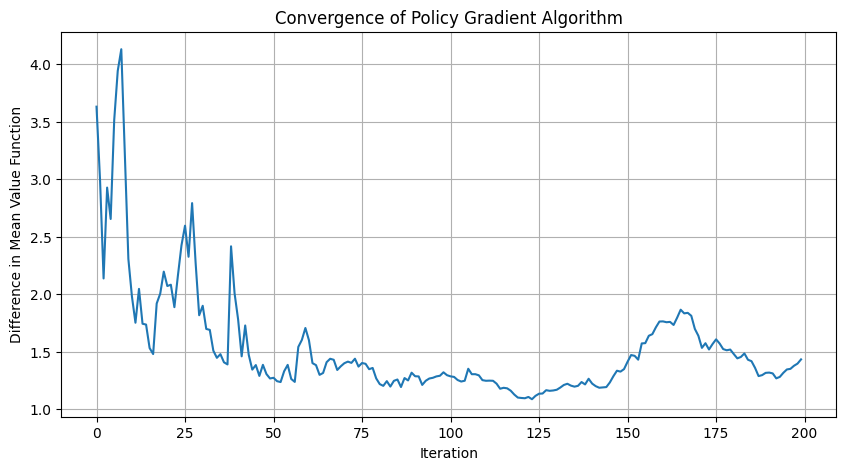

In [39]:
# Run 2 - lr 0.1 - 200 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

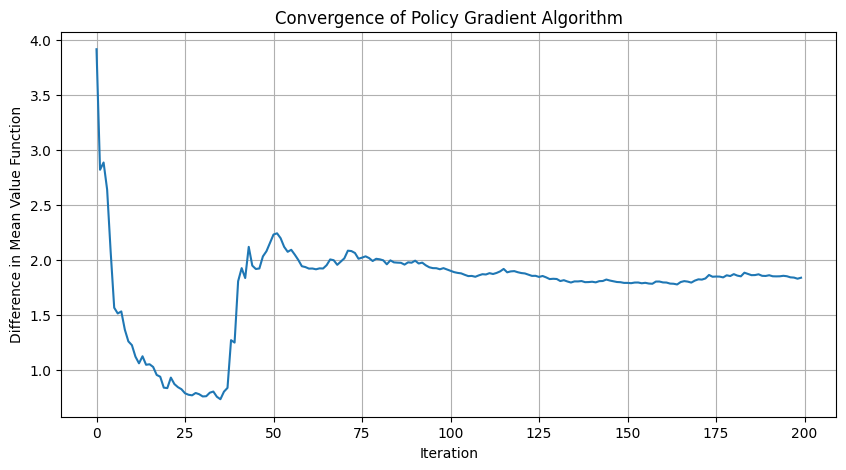

In [41]:
# Run 3 - lr 0.1 - 200 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

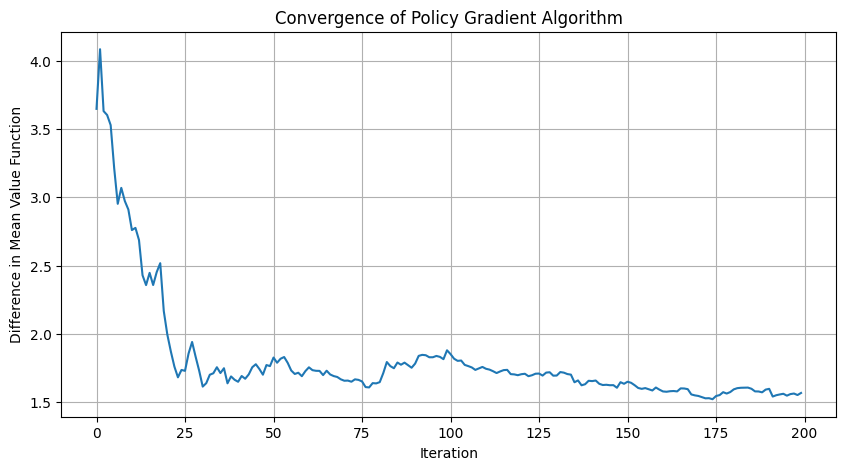

In [43]:
# Run 4 - lr 0.1 - 200 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

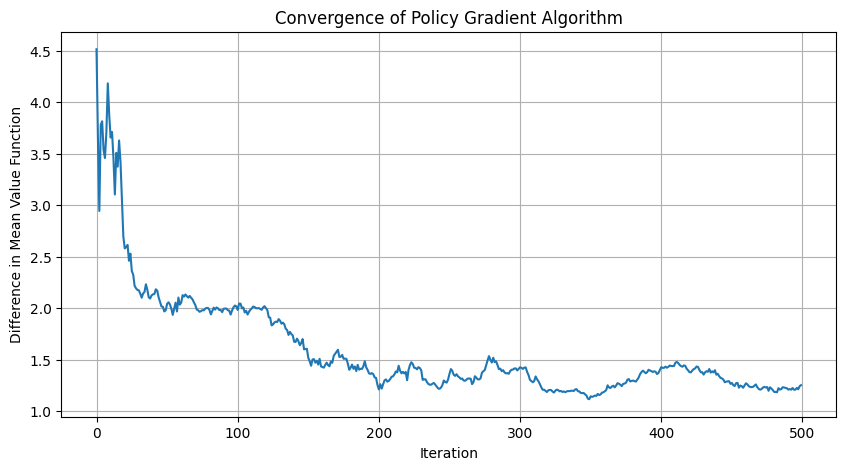

In [45]:
# Run 5 - lr 0.1 - 500 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

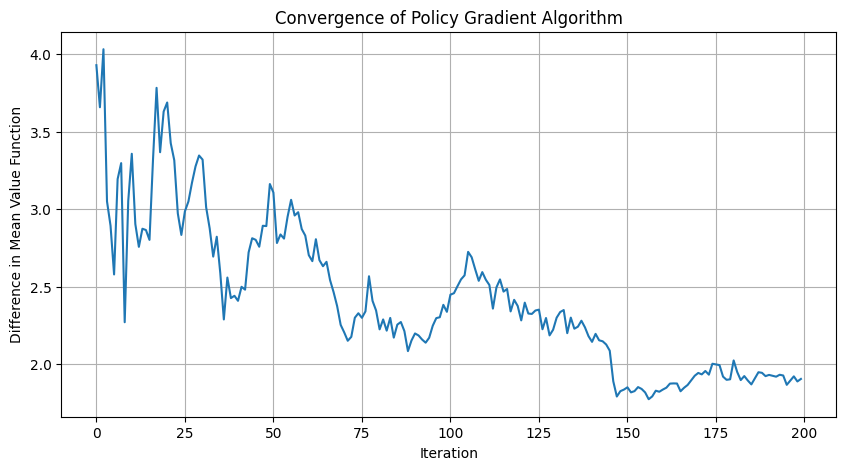

In [47]:
# Run 6 - lr 0.01 - 200 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

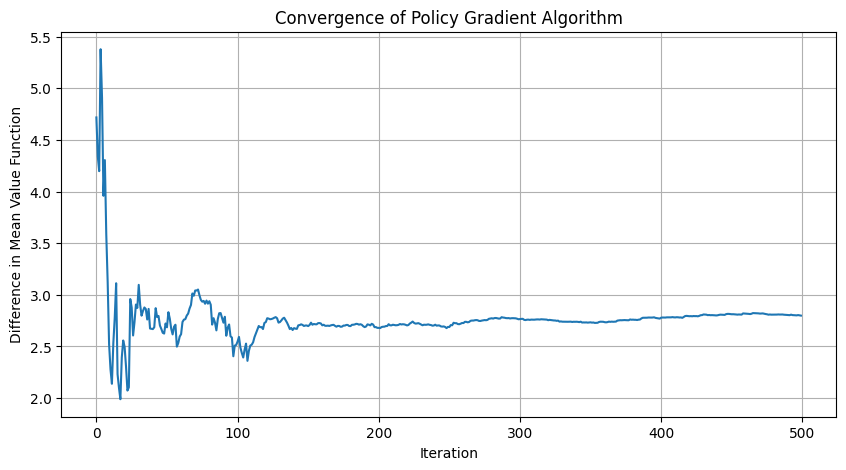

In [49]:
# Run 7 - lr 0.01 - 500 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

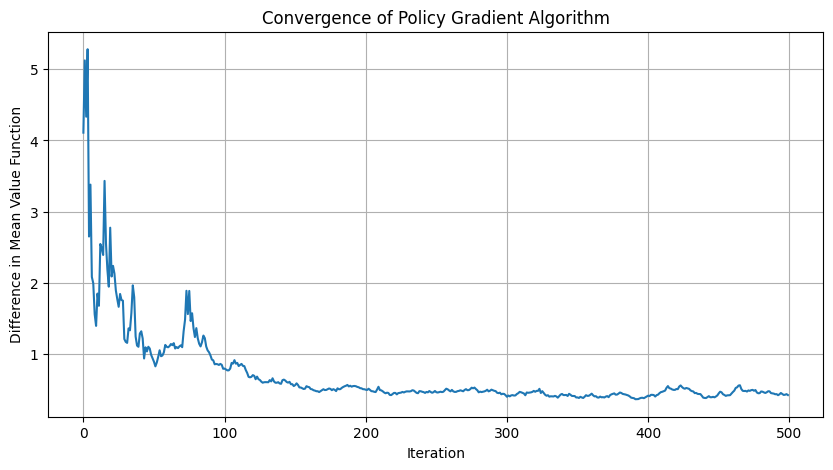

In [51]:
# Run 8 - lr 0.1 - 500 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

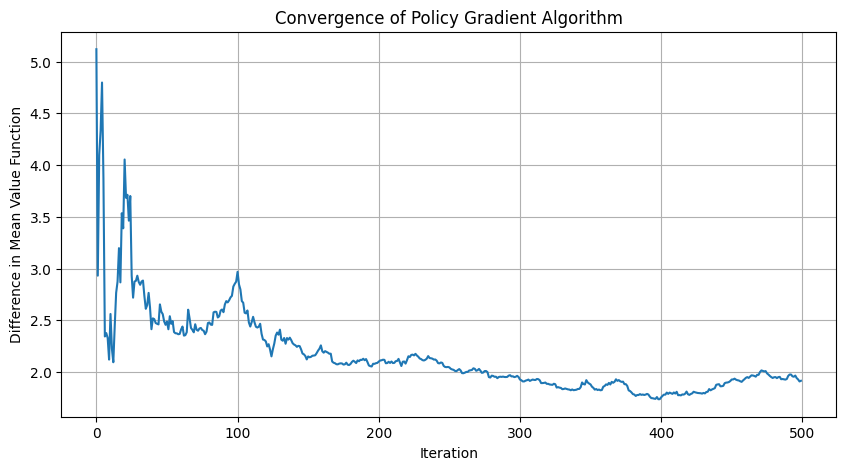

In [53]:
# Run 9 - lr 0.05 - 500 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

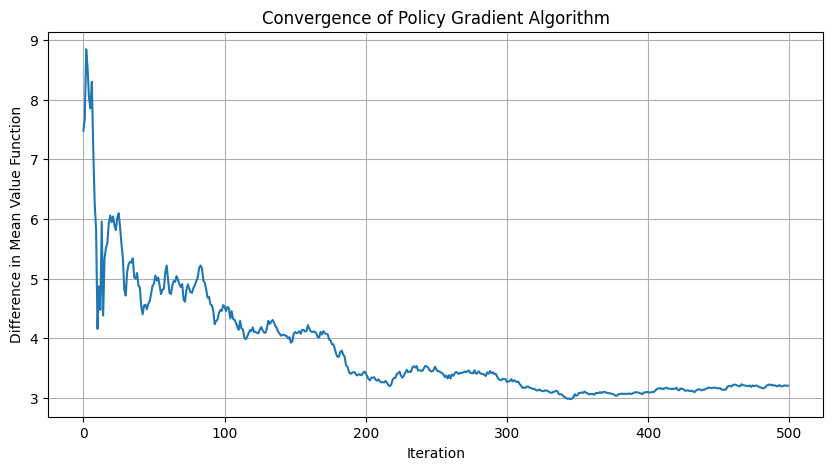

In [55]:
# Run 10 - lr 0.5 - 500 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

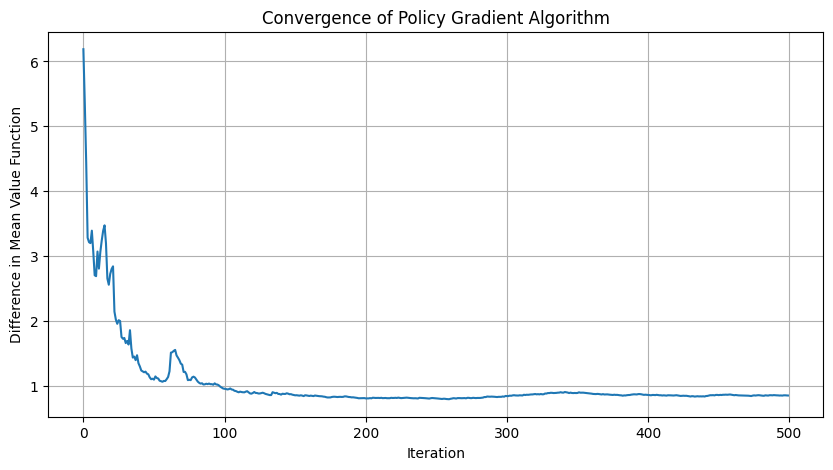

In [57]:
# Run 11 - lr 0.1 - 500 iter

iterations = range(nb_iter)

plt.figure(figsize=(10,5))
plt.plot(iterations, differences)
plt.xlabel('Iteration')
plt.ylabel('Difference in Mean Value Function')
plt.title('Convergence of Policy Gradient Algorithm')
plt.grid(True)
plt.show()

Why consider the mean?

The mean value function across all states provides a single scalar metric to evaluate the overall improvement of the policy.

What do you observe?

With the same parameters, differents runs lead to different convergence trends due to randomness.
Seems like there are not enough iterations to fully converge in some cases.

Higher learning rates speed up training but cause instability. The algorithm performs better with a learning rate of 0.1 and 500 iterations.